Device: cpu
HW08 dir: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08
Artifacts dir: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\artifacts
Figures dir: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\artifacts\figures
Data dir: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\data


100.0%


Sizes: {'train': 40000, 'val': 10000, 'test': 10000}
Batch x shape: torch.Size([128, 3, 32, 32])
Batch y shape: torch.Size([128])
x dtype: torch.float32 y dtype: torch.int64
x min/max: -1.0 1.0
y unique (first batch): tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
in_dim: 3072 num_classes: 10
E0: best_val_acc=0.5248 (epoch 14), best_val_loss=1.6195
E1: best_val_acc=0.5390 (epoch 12), best_val_loss=1.7177
E2: best_val_acc=0.5374 (epoch 12), best_val_loss=1.3413
E3: best_val_acc=0.5559 (epoch 10), best_val_loss=1.3786
Chosen for E4 (from E2/E3): E3 | E2: 0.537381329113924 E3: 0.5558742088607594
E4: best_val_acc=0.5559 (epoch 10), best_val_loss=1.3786, epochs_trained=14
Saved: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\artifacts\runs.csv
Best experiment: E3
Best val acc: 0.5558742088607594
Best val loss: 1.3786404019669642
Model: MLP(in=3072, hidden=[512, 256], out=10, drop=0.0, bn=True)
Saved: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSAN

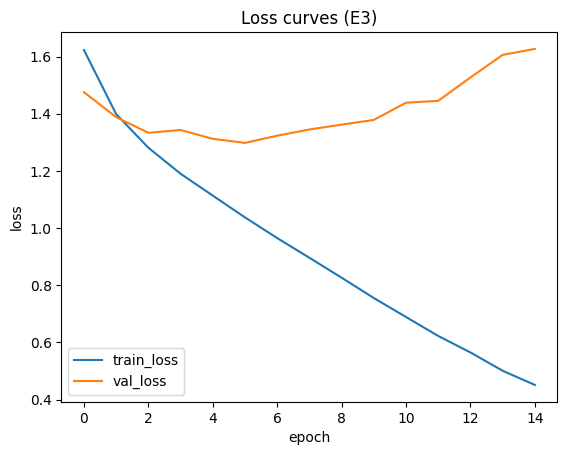

Saved: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\artifacts\figures\curves_best.png
Saved: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\artifacts\best_config.json
TEST: loss=1.3987, acc=0.5391
Updated with test metrics: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\artifacts\best_config.json
Saved: C:\Users\User\Desktop\GitHub Cafedra\Cafedra-AI-MALOFEEV-ALEXSANDR\homeworks\HW08\report.md


In [ ]:
import os
import json
import csv
import random
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


# ============ 2.3.1 Seed ============
SEED = 42

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Больше детерминизма (может замедлять, но тут не про скорость)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


# ============ 2.3.1 Device ============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ============ Paths (HW08, artifacts, data) ============
def resolve_hw08_dir() -> Path:
    """
    Делает так, чтобы артефакты сохранялись строго в homeworks/HW08/artifacts
    независимо от того, откуда запущен ноутбук.
    """
    cwd = Path.cwd().resolve()

    # 1) Ищем вверх по дереву папку homeworks/HW08
    for p in [cwd, *cwd.parents]:
        candidate = p / "homeworks" / "HW08"
        if candidate.exists():
            return candidate

    # 2) Если мы уже внутри HW08
    if cwd.name == "HW08":
        return cwd

    # 3) Фоллбек: создадим относительный путь от cwd
    return cwd / "homeworks" / "HW08"


hw_dir = resolve_hw08_dir()
artifacts_dir = hw_dir / "artifacts"
figures_dir = artifacts_dir / "figures"
artifacts_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

# Обычно data/ лежит в корне репо. Если hw_dir = <repo>/homeworks/HW08,
# то корень репо = hw_dir.parent.parent
if hw_dir.parent.name == "homeworks":
    repo_root = hw_dir.parent.parent
else:
    repo_root = Path.cwd().resolve()

data_dir = repo_root / "data"
data_dir.mkdir(parents=True, exist_ok=True)

print("HW08 dir:", hw_dir)
print("Artifacts dir:", artifacts_dir)
print("Figures dir:", figures_dir)
print("Data dir:", data_dir)


# ============ 2.2 Dataset choice ============
DATASET_NAME = "CIFAR10"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_ds = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)


# ============ 2.3.2 Train/Val split ============
TRAIN_RATIO = 0.8
n_train = int(len(full_train_ds) * TRAIN_RATIO)
n_val = len(full_train_ds) - n_train

split_gen = torch.Generator().manual_seed(SEED)
train_ds, val_ds = random_split(full_train_ds, [n_train, n_val], generator=split_gen)

print("Sizes:", {"train": len(train_ds), "val": len(val_ds), "test": len(test_ds)})


# ============ DataLoader ============
BATCH_SIZE = 128

def make_loaders(batch_size: int, seed: int):
    loader_gen = torch.Generator().manual_seed(seed + 12345)
    pin = (device.type == "cuda")

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        generator=loader_gen,
        num_workers=0,
        pin_memory=pin
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=pin
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=pin
    )
    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = make_loaders(BATCH_SIZE, SEED)

# ============ Sanity-check ============
xb, yb = next(iter(train_loader))
print("Batch x shape:", xb.shape)
print("Batch y shape:", yb.shape)
print("x dtype:", xb.dtype, "y dtype:", yb.dtype)
print("x min/max:", float(xb.min()), float(xb.max()))
print("y unique (first batch):", torch.unique(yb)[:20])


# ============ Model dims ============
in_dim = int(np.prod(xb.shape[1:]))   # 28*28=784
num_classes = 10
print("in_dim:", in_dim, "num_classes:", num_classes)


# ============ 2.3.3 MLP model ============
class MLPClassifier(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dims: list[int],
        num_classes: int,
        dropout_p: float = 0.0,
        use_batchnorm: bool = False
    ):
        super().__init__()
        self.flatten = nn.Flatten()

        layers = []
        prev = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout_p and dropout_p > 0:
                layers.append(nn.Dropout(p=dropout_p))
            prev = h

        layers.append(nn.Linear(prev, num_classes))  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        return self.net(x)


def model_summary_str(hidden_dims, dropout_p, use_batchnorm) -> str:
    return f"MLP(in={in_dim}, hidden={hidden_dims}, out={num_classes}, drop={dropout_p}, bn={use_batchnorm})"


# ============ Loss ============
criterion = nn.CrossEntropyLoss()


# ============ Metrics / Train / Eval ============
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return float((preds == y).float().mean().item())


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        total_acc += accuracy_from_logits(logits.detach(), y)
        n_batches += 1

    return total_loss / max(n_batches, 1), total_acc / max(n_batches, 1)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n_batches = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += float(loss.item())
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / max(n_batches, 1), total_acc / max(n_batches, 1)


# ============ 2.3.4 EarlyStopping ============
class EarlyStopping:
    def __init__(self, patience: int = 4, min_delta: float = 1e-4, mode: str = "max"):
        assert mode in ("max", "min")
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.bad_epochs = 0
        self.should_stop = False

    def step(self, metric: float) -> bool:
        if self.best is None:
            self.best = metric
            self.bad_epochs = 0
            self.should_stop = False
            return False

        if self.mode == "max":
            improved = metric > (self.best + self.min_delta)
        else:
            improved = metric < (self.best - self.min_delta)

        if improved:
            self.best = metric
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True

        return self.should_stop


def copy_state_dict_to_cpu(model: nn.Module) -> dict:
    return {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}


def fit_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    max_epochs: int,
    early_stopping=None
):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    best = {
        "epoch": -1,
        "val_acc": -float("inf"),
        "val_loss": float("inf"),
        "state_dict": None
    }

    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        if va_acc > best["val_acc"]:
            best["epoch"] = epoch
            best["val_acc"] = va_acc
            best["val_loss"] = va_loss
            best["state_dict"] = copy_state_dict_to_cpu(model)

        if early_stopping is not None:
            if early_stopping.step(va_acc):
                break

    epochs_trained = len(history["train_loss"])
    return history, best, epochs_trained


# ============ 2.3.4 Experiments E0-E3 ============
COMMON_TRAIN_CFG = {
    "batch_size": BATCH_SIZE,
    "lr": 1e-3,
    "max_epochs": 15
}

EXPERIMENTS = {
    "E0": {  # baseline
        "hidden_dims": [256],
        "dropout_p": 0.0,
        "batchnorm": False,
        "train_cfg": COMMON_TRAIN_CFG.copy(),
    },
    "E1": {  # deeper/wider
        "hidden_dims": [512, 256],
        "dropout_p": 0.0,
        "batchnorm": False,
        "train_cfg": COMMON_TRAIN_CFG.copy(),
    },
    "E2": {  # dropout
        "hidden_dims": [512, 256],
        "dropout_p": 0.3,
        "batchnorm": False,
        "train_cfg": COMMON_TRAIN_CFG.copy(),
    },
    "E3": {  # batchnorm
        "hidden_dims": [512, 256],
        "dropout_p": 0.0,
        "batchnorm": True,
        "train_cfg": COMMON_TRAIN_CFG.copy(),
    },
}


def run_experiment(exp_id: str, exp_cfg: dict):
    set_seed(SEED)
    train_loader, val_loader, _ = make_loaders(exp_cfg["train_cfg"]["batch_size"], SEED)

    model = MLPClassifier(
        in_dim=in_dim,
        hidden_dims=exp_cfg["hidden_dims"],
        num_classes=num_classes,
        dropout_p=exp_cfg["dropout_p"],
        use_batchnorm=exp_cfg["batchnorm"],
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=exp_cfg["train_cfg"]["lr"])

    history, best, epochs_trained = fit_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        max_epochs=exp_cfg["train_cfg"]["max_epochs"],
        early_stopping=None
    )

    result_row = {
        "experiment_id": exp_id,
        "dataset": DATASET_NAME,
        "seed": SEED,
        "model_summary": model_summary_str(exp_cfg["hidden_dims"], exp_cfg["dropout_p"], exp_cfg["batchnorm"]),
        "dropout": exp_cfg["dropout_p"],
        "batchnorm": exp_cfg["batchnorm"],
        "epochs_trained": epochs_trained,
        "best_epoch": best["epoch"],
        "best_val_accuracy": best["val_acc"],
        "best_val_loss": best["val_loss"],
    }
    return result_row, history, best


runs = []
histories = {}
best_states = {}
best_meta = {}

for exp_id in ["E0", "E1", "E2", "E3"]:
    row, hist, best = run_experiment(exp_id, EXPERIMENTS[exp_id])
    runs.append(row)
    histories[exp_id] = hist
    best_states[exp_id] = best["state_dict"]
    best_meta[exp_id] = best
    print(f"{exp_id}: best_val_acc={row['best_val_accuracy']:.4f} (epoch {row['best_epoch']}), best_val_loss={row['best_val_loss']:.4f}")


# ============ 2.3.4 Experiment E4 (EarlyStopping on best of E2/E3) ============
e2_acc = best_meta["E2"]["val_acc"]
e3_acc = best_meta["E3"]["val_acc"]
chosen_base = "E2" if e2_acc >= e3_acc else "E3"
print("Chosen for E4 (from E2/E3):", chosen_base, "| E2:", e2_acc, "E3:", e3_acc)

E4_CFG = {
    "hidden_dims": EXPERIMENTS[chosen_base]["hidden_dims"],
    "dropout_p": EXPERIMENTS[chosen_base]["dropout_p"],
    "batchnorm": EXPERIMENTS[chosen_base]["batchnorm"],
    "train_cfg": {
        "batch_size": BATCH_SIZE,
        "lr": 1e-3,
        "max_epochs": 30,
        "early_stopping_patience": 4
    }
}


def run_experiment_e4(exp_id: str, exp_cfg: dict):
    set_seed(SEED)
    train_loader, val_loader, _ = make_loaders(exp_cfg["train_cfg"]["batch_size"], SEED)

    model = MLPClassifier(
        in_dim=in_dim,
        hidden_dims=exp_cfg["hidden_dims"],
        num_classes=num_classes,
        dropout_p=exp_cfg["dropout_p"],
        use_batchnorm=exp_cfg["batchnorm"],
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=exp_cfg["train_cfg"]["lr"])
    es = EarlyStopping(patience=exp_cfg["train_cfg"]["early_stopping_patience"], mode="max")

    history, best, epochs_trained = fit_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        max_epochs=exp_cfg["train_cfg"]["max_epochs"],
        early_stopping=es
    )

    result_row = {
        "experiment_id": exp_id,
        "dataset": DATASET_NAME,
        "seed": SEED,
        "model_summary": model_summary_str(exp_cfg["hidden_dims"], exp_cfg["dropout_p"], exp_cfg["batchnorm"]),
        "dropout": exp_cfg["dropout_p"],
        "batchnorm": exp_cfg["batchnorm"],
        "epochs_trained": epochs_trained,
        "best_epoch": best["epoch"],
        "best_val_accuracy": best["val_acc"],
        "best_val_loss": best["val_loss"],
    }
    return result_row, history, best


row, hist, best = run_experiment_e4("E4", E4_CFG)
runs.append(row)
histories["E4"] = hist
best_states["E4"] = best["state_dict"]
best_meta["E4"] = best
print(f"E4: best_val_acc={row['best_val_accuracy']:.4f} (epoch {row['best_epoch']}), best_val_loss={row['best_val_loss']:.4f}, epochs_trained={row['epochs_trained']}")


# ============ 2.4 Save runs.csv ============
runs_csv_path = artifacts_dir / "runs.csv"
fieldnames = [
    "experiment_id", "dataset", "seed", "model_summary",
    "dropout", "batchnorm", "epochs_trained", "best_epoch",
    "best_val_accuracy", "best_val_loss"
]

with open(runs_csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for r in runs:
        writer.writerow(r)

print("Saved:", runs_csv_path)


# ============ 2.3.5 Choose best by val_accuracy ============
best_run = sorted(
    runs,
    key=lambda r: (r["best_val_accuracy"], -r["best_val_loss"]),
    reverse=True
)[0]

best_exp_id = best_run["experiment_id"]
print("Best experiment:", best_exp_id)
print("Best val acc:", best_run["best_val_accuracy"])
print("Best val loss:", best_run["best_val_loss"])
print("Model:", best_run["model_summary"])


def exp_cfg_from_id(exp_id: str) -> dict:
    if exp_id in EXPERIMENTS:
        return EXPERIMENTS[exp_id]
    if exp_id == "E4":
        return E4_CFG
    raise KeyError(f"Unknown exp_id: {exp_id}")


best_cfg = exp_cfg_from_id(best_exp_id)


# ============ 2.4 Save best_model.pt ============
best_model_path = artifacts_dir / "best_model.pt"
torch.save(best_states[best_exp_id], best_model_path)
print("Saved:", best_model_path)


# ============ 2.4 Save curves_best.png ============
hist = histories[best_exp_id]

plt.figure()
plt.plot(hist["train_loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"Loss curves ({best_exp_id})")
plt.legend()
curves_path = figures_dir / "curves_best.png"
plt.savefig(curves_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved:", curves_path)


# ============ 2.4 Save best_config.json ============
best_config_path = artifacts_dir / "best_config.json"
best_config = {
    "experiment_id": best_exp_id,
    "dataset": DATASET_NAME,
    "seed": SEED,
    "split": {"train_ratio": TRAIN_RATIO, "val_ratio": 1.0 - TRAIN_RATIO},
    "train": {
        "batch_size": int(best_cfg["train_cfg"]["batch_size"]),
        "lr": float(best_cfg["train_cfg"]["lr"]),
        "max_epochs": int(best_cfg["train_cfg"]["max_epochs"]),
        "early_stopping_patience": int(best_cfg["train_cfg"].get("early_stopping_patience", 0))
    },
    "model": {
        "in_dim": int(in_dim),
        "hidden_dims": list(best_cfg["hidden_dims"]),
        "num_classes": int(num_classes),
        "dropout_p": float(best_cfg["dropout_p"]),
        "batchnorm": bool(best_cfg["batchnorm"]),
    },
    "best_val": {
        "accuracy": float(best_run["best_val_accuracy"]),
        "loss": float(best_run["best_val_loss"]),
        "epoch": int(best_run["best_epoch"]),
    }
}

with open(best_config_path, "w", encoding="utf-8") as f:
    json.dump(best_config, f, ensure_ascii=False, indent=2)

print("Saved:", best_config_path)


# ============ 2.3.4 Test evaluation (once) ============
_, _, test_loader = make_loaders(best_config["train"]["batch_size"], SEED)

best_model = MLPClassifier(
    in_dim=best_config["model"]["in_dim"],
    hidden_dims=best_config["model"]["hidden_dims"],
    num_classes=best_config["model"]["num_classes"],
    dropout_p=best_config["model"]["dropout_p"],
    use_batchnorm=best_config["model"]["batchnorm"],
).to(device)

best_model.load_state_dict(best_states[best_exp_id])
best_model.eval()

test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)
print(f"TEST: loss={test_loss:.4f}, acc={test_acc:.4f}")

best_config["test"] = {"loss": float(test_loss), "accuracy": float(test_acc)}
with open(best_config_path, "w", encoding="utf-8") as f:
    json.dump(best_config, f, ensure_ascii=False, indent=2)

print("Updated with test metrics:", best_config_path)


# ============ report.md generation ============
report_path = hw_dir / "report.md"

report_text = f"""# HW08 Report

## Datasets
- Dataset: {DATASET_NAME}
- Transform: ToTensor + Normalize((0.5,), (0.5,))
- Split: train/val = {int(TRAIN_RATIO*100)}/{int((1-TRAIN_RATIO)*100)} with seed={SEED}

## Experiments (E0–E4)
Таблица прогонов: [artifacts/runs.csv](artifacts/runs.csv)

Best by validation accuracy:
- experiment_id: {best_config["experiment_id"]}
- best_val_accuracy: {best_config["best_val"]["accuracy"]:.4f}
- best_val_loss: {best_config["best_val"]["loss"]:.4f}
- best_epoch: {best_config["best_val"]["epoch"]}

## Best model artifacts
- Weights: [artifacts/best_model.pt](artifacts/best_model.pt)
- Config: [artifacts/best_config.json](artifacts/best_config.json)
- Curves: ![curves](artifacts/figures/curves_best.png)

## Test evaluation (only once for the selected best model)
- test_accuracy: {best_config["test"]["accuracy"]:.4f}
- test_loss: {best_config["test"]["loss"]:.4f}

## Conclusions
- E0 is a baseline.
- E1 increases capacity and may overfit.
- E2 adds Dropout regularization.
- E3 adds BatchNorm stabilization.
- E4 trains the best of (E2/E3) with EarlyStopping and saves artifacts.
"""

with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_text)

print("Saved:", report_path)